# Advanced Tutorial 3 : build a Spectral Deferred Correction solver for non-linear ODEs

📜 _Previous base tutorial on [SDC](./04_sdc.ipynb) focused on the Dahlquist problem to explain how to use the_ $Q_\Delta$_-coefficients._
_But we can also use those for non-linear ODEs **as long as**_ $Q_\Delta$ _**is lower triangular**._

Back to the **all-at-once system** defined for the [previous tutorial](./12_nonLinearRK.ipynb) :

$$
{\bf u} - \Delta{t}Q {\bf f} = {\bf u}_0,
$$

with $Q$ a **dense matrix**. We still want to be able to solve this system using only :

- evaluation of $f(u,t)$
- solution of $u-\alpha f(u,t) = rhs$ for any $\alpha,t,rhs$

Then, we consider the preconditioned iteration to solve the all-at-once system :

$$
(I - \Delta{t}Q_\Delta F)({\bf u}^{k+1} - {\bf u}^{k}) = {\bf u}_0 - ({\bf u}^{k} - \Delta{t}Q {\bf f}^{k})
$$

where 
${\bf u}^{k} := [u_1^k, \dots, u_M^k]^T$ the vector of node solutions at the 
$k^{th}$ iteration and
${\bf f}^{k} := [f(u_1^k, t_1), \dots, f(u_M^k, t_M)]^T$ the evaluation of each 
node solution. We use the notation
$I,F$ for the identity operator and $f$ evaluation, respectively.

The iteration can be rewritten and simplified into

$$
{\bf u}^{k+1} - \Delta{t}Q_\Delta {\bf f}^{k+1}
    = {\bf u}_0 + \Delta{t}(Q-Q_\Delta) {\bf f}^{k}
$$

which can be solved node by node for each iteration, as long as $Q_\Delta$ is **lower triangular**.

## Prerequisite

We use the same as for the [previous tutorial](./12_nonLinearRK.ipynb) :

In [1]:
import numpy as np
from scipy.optimize import fsolve

u0 = np.array([5, -5, 20])
sigma, rho0, beta, epsilon = 10, 28, 8/3, 5


def f(u, t):
    x, y, z = u
    rho = rho0 + epsilon*np.sin(t)
    return np.array([sigma*(y-x), x*(rho-z)-y, x*y-beta*z])


def fSolve(a, t, rhs, uInit):

    def res(u):
        return u - a*f(u, t) - rhs

    return fsolve(res, uInit)

## Implementation

Let's retrieve $Q$ and $Q_\Delta$ coefficients fom `qmat`, using the `Collocation` class as base 

In [2]:
from qmat.qcoeff.collocation import Collocation
from qmat import genQDeltaCoeffs

qGen = Collocation(nNodes=4, nodeType="LEGENDRE", quadType="RADAU-RIGHT")
nodes, weights, Q = qGen.genCoeffs()
QDelta = genQDeltaCoeffs("BE", qGen=qGen)

> 📜 Checkout the [tutorial on nodes generation](./22_nodes.ipynb) for details about `nodeType` and `quadType`.

Then we define some arrays to store the node solutions for each iterations (considering here $K=4$ sweeps), 
the step solutions and time values : 

In [3]:
nSweeps = 4
uNodes = np.zeros((nSweeps+1, nodes.size, u0.size))     # k=0,...,K => (nSweeps+1) node solutions vectors

tEnd = 10
nSteps = 1000

uNum = np.zeros((nSteps+1, u0.size))
times = np.linspace(0, tEnd, nSteps+1)

Now, for each time step, time node and iteration, we have to solve

$$
u_m^{k+1} - \Delta{t} q^\Delta_{m,m} f(u_m^{k+1},t_m)
    = u_0 + \Delta{t} \sum_{j=1}^{M} q_{m,j}f(u_j^{k},t_j)
    + \Delta{t} \sum_{j=1}^{m-1} q^\Delta_{m,j}f(u_j^{k+1},t_j)
    - \Delta{t} \sum_{j=1}^{m} q^\Delta_{m,j}f(u_j^{k},t_j)
$$

and compute the step update before next step :

$$
u(t_0 + \Delta{t}) \simeq u_0 + \sum_{m=1}^{M} \omega_{m} f(u_m, t_m).
$$

This can be done with the following code :

In [4]:
uNum[0] = u0
for i in range(nSteps):
    dt = times[i+1] - times[i]
    tNodes = times[i] + dt*nodes

    # Initialize k=0 with u0
    uNodes[0][:] = uNum[i]

    # Iteration loop
    for k in range(nSweeps):

        # Loop on nodes
        for m in range(len(nodes)):
            rhs = uNum[i].copy()

            # Quadrature terms
            for j in range(len(nodes)):
                rhs += dt*Q[m, j]*f(uNodes[k, j], tNodes[j])

            # Correction terms
            for j in range(m):
                rhs += dt*QDelta[m, j]*f(uNodes[k+1, j], tNodes[j])
            for j in range(m+1):
                rhs -= dt*QDelta[m, j]*f(uNodes[k, j], tNodes[j])

            if QDelta[m,m] == 0:
                uNodes[k+1, m] = rhs
            else:
                uNodes[k+1, m] = fSolve(dt*QDelta[m, m], tNodes[m], rhs, uInit=uNodes[k, m])

    # Step update
    uNum[i+1] = uNum[i]
    for m in range(len(nodes)):
        uNum[i+1] += dt*weights[m]*f(uNodes[-1, m], tNodes[m])

And that's it 🥳 ! We solved our non-linear time-dependent ODE on the given time frame using 4 SDC sweeps, 
without caring about what's in our $Q$ and $Q_\Delta$ coefficients  ...

> 🔍 For a **strictly lower triangular** $Q_\Delta$ **matrix** (`QDelta[m,m]=0`), there is no need for the `fSolve` function (as for the RK methods in [previous tutorial](./12_nonLinearRK.ipynb)).
> We talk then about **explicit SDC sweeps**.

> 💡 Here the same $Q_\Delta$ matrix is used for all sweeps, but nothing prevent to use different $Q_\Delta$ coefficient
> for each different sweeps. We just have to generate a $Q_\Delta$ matrix with shape `(nSweeps, nNodes, nNodes)`,
> which is allowed using the `nSweeps` optional parameter of `genQDeltaCoeffs`. 

Finally, we can plot the solution with respect to time : 

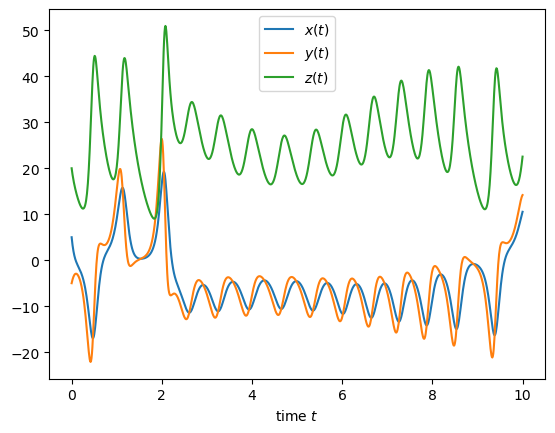

In [5]:
import matplotlib.pyplot as plt

plt.plot(times, uNum[:, 0], label="$x(t)$")
plt.plot(times, uNum[:, 1], label="$y(t)$")
plt.plot(times, uNum[:, 2], label="$z(t)$")
plt.legend(); plt.xlabel("time $t$");

Ideally, the previous code can be written into a function to allow multiple calls :

In [6]:
def solveSDC(nSteps, nSweeps, scheme):
    qGen = Collocation(nNodes=4, nodeType="LEGENDRE", quadType="RADAU-RIGHT")
    nodes, weights, Q = qGen.genCoeffs()
    QDelta = genQDeltaCoeffs(scheme, qGen=qGen)

    uNodes = np.zeros((nSweeps+1, nodes.size, u0.size))

    tEnd = 10
    uNum = np.zeros((nSteps+1, u0.size))
    times = np.linspace(0, tEnd, nSteps+1)

    uNum[0] = u0
    for i in range(nSteps):
        dt = times[i+1] - times[i]
        tNodes = times[i] + dt*nodes

        # Initialize k=0 with u0
        uNodes[0][:] = uNum[i]

        # Iteration loop
        for k in range(nSweeps):

            # Loop on nodes
            for m in range(len(nodes)):
                rhs = uNum[i].copy()

                # Quadrature terms
                for j in range(len(nodes)):
                    rhs += dt*Q[m, j]*f(uNodes[k, j], tNodes[j])

                # Correction terms
                for j in range(m):
                    rhs += dt*QDelta[m, j]*f(uNodes[k+1, j], tNodes[j])
                for j in range(m+1):
                    rhs -= dt*QDelta[m, j]*f(uNodes[k, j], tNodes[j])

                if QDelta[m,m] == 0:
                    uNodes[k+1, m] = rhs
                else:
                    uNodes[k+1, m] = fSolve(dt*QDelta[m, m], tNodes[m], rhs, uInit=uNodes[k, m])

        # Step update
        uNum[i+1] = uNum[i]
        for m in range(len(nodes)):
            uNum[i+1] += dt*weights[m]*f(uNodes[-1, m], tNodes[m])

    return times, uNum

... which can be used to try different SDC schemes, number of sweeps or time resolution :

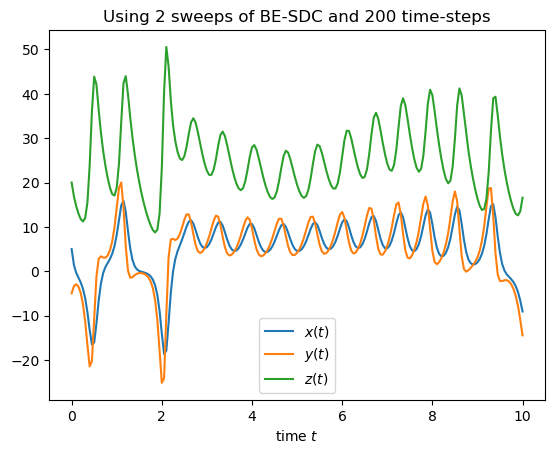

In [7]:
times, uNum = solveSDC(200, 2, "BE")
plt.plot(times, uNum[:, 0], label="$x(t)$")
plt.plot(times, uNum[:, 1], label="$y(t)$")
plt.plot(times, uNum[:, 2], label="$z(t)$")
plt.legend(); plt.xlabel("time $t$"); plt.title("Using 2 sweeps of BE-SDC and 200 time-steps");

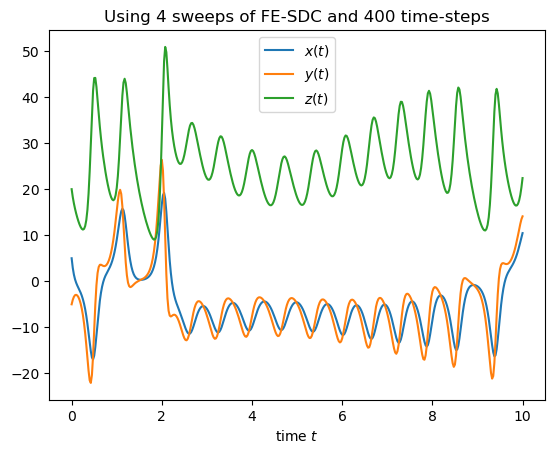

In [8]:
times, uNum = solveSDC(400, 4, "FE")
plt.plot(times, uNum[:, 0], label="$x(t)$")
plt.plot(times, uNum[:, 1], label="$y(t)$")
plt.plot(times, uNum[:, 2], label="$z(t)$")
plt.legend(); plt.xlabel("time $t$"); plt.title("Using 4 sweeps of FE-SDC and 400 time-steps");

## Using the internal SDC solver

Such generic SDC solver is also available in the `qmat.solvers.generic.CoeffSolver` class,
and uses a more efficient implementation than the one showed above, requiring less evaluation of $f(u,t)$.
This implementation is based on the `DiffOp` class that implements the $f(u,t)$ evaluations,
see the last part of the [previous tutorial](./12_nonLinearRK.ipynb) for more details.

Looking at the non-perturbed Lorenz example problem, we can solve it with SDC using those few lines :

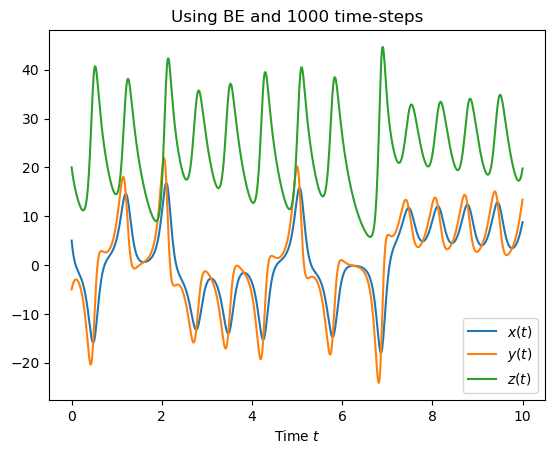

In [9]:
from qmat import genQDeltaCoeffs
from qmat.qcoeff.collocation import Collocation
from qmat.solvers.generic import CoeffSolver
from qmat.solvers.generic.diffops import Lorenz

scheme = "BE"
nSteps = 1000
nSweeps = 4

qGen = Collocation(nNodes=4, nodeType="LEGENDRE", quadType="RADAU-RIGHT")
nodes, weights, Q = qGen.genCoeffs()
QDelta = genQDeltaCoeffs(scheme, qGen=qGen)

solver = CoeffSolver(Lorenz(), tEnd=10, nSteps=nSteps)
uNum = solver.solveSDC(nSweeps, Q, weights, QDelta)

plt.plot(solver.times, uNum[:, 0], label="$x(t)$")
plt.plot(solver.times, uNum[:, 1], label="$y(t)$")
plt.plot(solver.times, uNum[:, 2], label="$z(t)$")
plt.legend(); plt.xlabel("Time $t$"); plt.title(f"Using {scheme} and {nSteps} time-steps");

Eventually, you can also add your own differential operator into `qmat`, see the [short developer guide](../devdoc/addDiffOp.md) on this aspect ...

> 💡 This coefficient-based approach for SDC, relying on a $Q_\Delta$ matrix, allows many different variants by just changing the $Q_\Delta$ coefficients. However, it always relies on multi-node (or multi-stage) methods to define 
> the approximate time-integrator used for the SDC sweeps.
>
> But one can also define SDC in an even more generic way, using a $\phi$-based representation of time integrators,
> which is the topic of the [next tutorial](./14_phiIntegrator.ipynb).